### Installations

In [1]:
# Installations to be done apart from tensorflow and keras.
# !pip install scikit-learn
# !pip install scikit-image
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm

### Imports

Imports used in the code

In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import data, io, filters
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, Input
from keras import layers
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from collections import OrderedDict
import json

### F1
Functions used to produce F1 score.

In [6]:
# Used later for f1 score
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Read the file
Read the file, check if the data is clean (it is). Check the number of instance for each category (the cell has beenn removed). Then one-hot encoding of the classes. The cell with the data split was used to try different models and chose between them (and to know real results and not just the overfitted ones).

In [36]:
# Read the file
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [8]:
# One hot encoding
df['p'] = df['label'].apply(lambda x : 1 if x==0 else 0)
df['g'] = df['label'].apply(lambda x : 1 if x==1 else 0)
df['s'] = df['label'].apply(lambda x : 1 if x==2 else 0)
df

,label,latitude,longitude,year,example_path,p,g,s
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png,1,0,0
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png,0,0,1
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png,1,0,0
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png,1,0,0
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png,1,0,0
...,...,...,...,...,...,...,...,...
1709,0,3.819464,117.636112,2016,train_test_data/train/550.png,1,0,0
1710,0,-1.809594,111.531951,2005,train_test_data/train/2264.png,1,0,0
1711,1,0.443397,112.200163,2012,train_test_data/train/1486.png,0,1,0
1712,2,-1.978349,101.970148,2012,train_test_data/train/1170.png,0,0,1


In [19]:
# Load the datasets 
X_dataset = []
X_test = []
y = np.array(df[['p','g','s']])

for i in tqdm(range(df.shape[0])):
    img = io.imread(df.iloc[i]['example_path'])
    img = img/255.
    X_dataset.append(resize(img,(224,224,3)))
X = np.array(X_dataset)

for i in tqdm(range(df_test.shape[0])):
    img = io.imread(df.iloc[i]['example_path'])
    img = img/255.
    X_test.append(resize(img,(224,224,3)))
X_test = np.array(X_test) 

100%|██████████| 635/635 [00:08<00:00, 70.95it/s]


In [22]:
# Split for model selection purposes
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)
# Use next line with end model
X_train = X
y_train = y

### Data augmentation
The quantity of data is not balanced. Augment the data and try to balance it. In the presentation is explained how it was done

In [23]:
# Data augmentation. Augment only train data. 
train_datagen = ImageDataGenerator(
    rotation_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

X = []
for i in X_train:
    X.append(i)
    
number_gen = 2
for i in tqdm(range(len(X_train))):
    gen = train_datagen.flow(X_train[i:i+1])
    
    # Equilibrate classes
    if y_train[i][1] == 1:
        number_gen = 7
    else:
        number_gen = 2
        
    for j in range(number_gen):
        y_train = np.vstack([y_train, y_train[i]])
        X.append(gen[0][0])
        
X_train = np.array(X)

100%|██████████| 1714/1714 [00:30<00:00, 56.24it/s]


### Select model
We have tried VGG16, ResNet50 and other models. We also tried our own models. With out own model we obtained 74-76 accuracy on validation. With VGG16 the same. ResNet550 less. The best option that we found is MobileNet obtaining 79-82.

In [26]:
# Download pretrained model.
mobile = tf.keras.applications.mobilenet.MobileNet()

In [27]:
# Add our layers. We have seen that the best option is with 1 Dense at the end.
m = mobile.layers[-6].output
output = Dense(units=3, activation="softmax")(m)

In [29]:
model = Model(inputs=mobile.input, outputs=output)

In [30]:
# Set the first, more general part, of the pretrained network as non-trainable.
for layer in model.layers[:-23]:
    layer.trainable = False

In [31]:
# Show the model
# model.summary()

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',f1_m])

# Train
We have seen that the model overfits rapidly. How ever, there are some epochs where the loss of validation test stills being the same but the accuracy gets better. We have seen that the best epoch value for our case is 20.

In [33]:
history = model.fit(X_train , y_train, epochs=20, batch_size = 64)

Epoch 1/20
96/96 [==============================] - 12s 71ms/step - loss: 0.6827 - accuracy: 0.7164 - f1_m: 0.7036
Epoch 2/20
96/96 [==============================] - 6s 63ms/step - loss: 0.3213 - accuracy: 0.8922 - f1_m: 0.8879
Epoch 3/20
96/96 [==============================] - 6s 63ms/step - loss: 0.1924 - accuracy: 0.9526 - f1_m: 0.9529
Epoch 4/20
96/96 [==============================] - 6s 63ms/step - loss: 0.1144 - accuracy: 0.9856 - f1_m: 0.9860
Epoch 5/20
96/96 [==============================] - 6s 63ms/step - loss: 0.0740 - accuracy: 0.9959 - f1_m: 0.9953
Epoch 6/20
96/96 [==============================] - 6s 63ms/step - loss: 0.0503 - accuracy: 0.9985 - f1_m: 0.9986
Epoch 7/20
96/96 [==============================] - 6s 62ms/step - loss: 0.0341 - accuracy: 1.0000 - f1_m: 0.9999
Epoch 8/20
96/96 [==============================] - 6s 63ms/step - loss: 0.0264 - accuracy: 0.9997 - f1_m: 0.9995
Epoch 9/20
96/96 [==============================] - 6s 63ms/step - loss: 0.0203 - accur

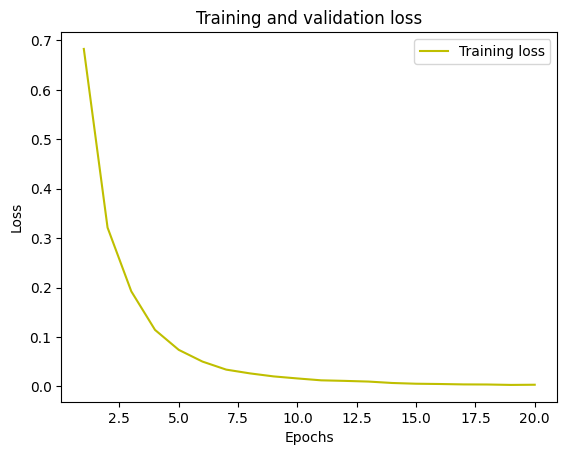

In [39]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Predict
y_pred = model.predict(X_test)

### Save the prediction

In [42]:
# Save the results
from collections import OrderedDict
import json

def dump_preds(y_pred, filename='predictions.json'):

    y_cats = np.argmax(y_pred, axis=1).tolist()
    od = OrderedDict(zip(range(len(y_cats)), y_cats))
    jsonfinal = {"target": od}

    with open(filename, 'w') as json_file:
        json.dump(jsonfinal, json_file)
        
dump_preds(y_pred)